In [2]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, load_model
from tensorflow import keras
from IPython.display import Image, display

In [3]:
def get_img_array(img_path, size):
    """
    Return a numpy array containing the image read from
    `img_path` and resized to `size`
    Args:
        img_path (str): path to image
        size (tuple): desired dimension for the image

    Returns:
        [numpy.ndarray]: the loaded image
    """
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [4]:
img_size = (128, 128)
img_path = 'COVID-3293.png'
model_path = 'damn.h5'

float32 0.0 0.8705883


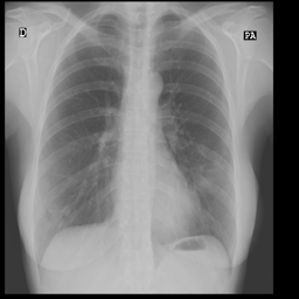

In [5]:
test_img = get_img_array(img_path, img_size)
# test_img = preprocess_input(test_img)
test_img *= 1/255
print(test_img.dtype, test_img.min(), test_img.max())

# Pentru a o afișa vom folosi funcția display din IPython
# care încarcă din nou imaginea de pe disk într-un alt tip de obiect
display(Image(img_path, width=400, height=400))

In [6]:
# Load model that containes a network inside a layer
orig_model = load_model(model_path)
orig_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


Modelul salvat conține o întreagă rețea în interiorul unui strat. În exemplu de față, stratul vgg16 conține toată rețeaua vgg16 până la straturile fully-connected. Primul pas este să extragem această rețea într-o nouă variabilă. Vom copia/clona această rețea, mai exact arhitectura ei. **`clone_model` nu copiază și weights-urile, ci le re-inițializează**. Pentru a copia și weights-urile salvate în `orig_model` se folosesc funcțiile `set_weights` și `get_weights`. `cloned_model.summary()` va afișa toate straturile din vgg16 spre deosebire de `orig_model.summary()`

In [7]:
cloned_model = tf.keras.models.clone_model(orig_model.get_layer('vgg16'))
cloned_model.set_weights(orig_model.get_layer('vgg16').get_weights())
cloned_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

Următorul pas este să copiem și weights-urile pentru celelalte straturi din `orig_model` care au fost adăugat după stratul vgg16: flatten, dense și dense_1. |**Acestea vor fi recreate de la zero, folosind functional API din keras. Acestea trebuie să conțină exact același nr de neuroni, funcții de activare, etc ca și cele din `orig_model`**. Apoi, acestea vor fi "unite" cu straturile din `cloned_model`.

In [8]:
x = tf.keras.layers.Flatten()(cloned_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# bind all
new_model = tf.keras.Model(cloned_model.input, output)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

Ca și înainte, copiem weights-urile acestor straturi din `orig_model`. Stratul `Flatten` nu are weights-uri.

In [9]:
new_model.get_layer('dense').set_weights(orig_model.get_layer('dense').get_weights())
new_model.get_layer('dense_1').set_weights(orig_model.get_layer('dense_1').get_weights())

Verificăm dacă predicțiile celor două modele, `orig_model` și `new_model` sunt la fel. Acestea conțin aceleași weights-uri, deci și predicțiile ar trebui să fie la fel pentru aceeași imagine.

In [10]:
orig_pred = orig_model.predict(test_img)
new_pred = new_model.predict(test_img)
print(orig_pred, new_pred)
assert orig_pred == new_pred

[[0.8737052]] [[0.8737052]]


Acum, se poate folosi clasa `GradCAM` pentru generarea heatmap-ului.

In [11]:
# se va folosi clasa GradCAM pentru a calcula heatmap-ul
from GradCAM import GradCAM

# se citește imaginea folosind OpenCV
# by default ordinea canalelor este BGR
orig = cv2.imread(img_path)
resized = cv2.resize(orig, img_size)

# se calculează heatmap prin trecerea unei imagini de intrare în format Keras
# By defacult, GradCAM va crea un heatmap pentru clasa cu predicția cea mai mare, 
# însă se poate specifica și alt index folosind parametrul classIdx
grad_cam = GradCAM(new_model, layerName='block5_conv3')
heatmap = grad_cam.compute_heatmap(test_img)


# heatmap-ul rezultat este redimensionat la dimensiunea imaginii de intrare originale
# si apoi suprapus peste aceasta
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = grad_cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# se salvează rezultatul
cv2.imwrite("grad_cam_output.jpg", output)

True

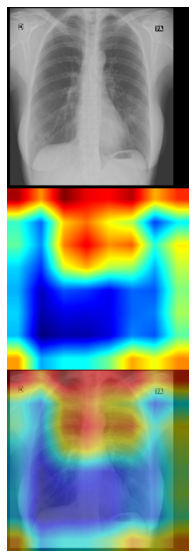

In [12]:
# se afișează imaginea original, heatmap și rezultatul final (heatmap suprapus peste imagine)
# toate aceste 3 imagini sunt în format OpenCV, adică ordinea este BGR
# pentru afișare cu matplotlib canalele trebuie reordonate în RGB
display_output = np.vstack([orig[:, :, [2, 1, 0]], heatmap[:, :, [2, 1, 0]], output[:, :, [2, 1, 0]]])
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_axis_off()
ax.imshow(display_output)